<a href="https://colab.research.google.com/github/sahal-mulki/aerolens/blob/main/prophet-TEMPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy earthaccess netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.5.0
    Uninstalling tenacity-8.5.0:
      Successfully uninstalled tenacity-8.5.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the s

In [2]:
import earthaccess  # needed to discover and download TEMPO data
import netCDF4 as nc  # needed to read TEMPO data
import numpy as np

import matplotlib.pyplot as plt  # needed to plot the resulting time series
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
auth = earthaccess.login(persist=True)

Enter your Earthdata Login username: sahalmulki
Enter your Earthdata password: ··········


In [4]:
short_name = "TEMPO_NO2_L3"  # collection name to search for in the EarthData
version = "V03"

# Point of interest: NASA Langley Research Center, HamptonVA, USA
# latitude 37.1036 deg, longitude -76.3868 deg
POI_lat = 37.1036
POI_lon = -76.3868

# generic location, somewhere in the middle of the USA
#POI_lat = 38.0
#POI_lon = -96.0
date_start = "2025-09-01 00:00:00"
date_end = "2025-09-05 23:59:59"

In [5]:
POI_results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    temporal=(date_start, date_end),
    point=(POI_lon, POI_lat),  # search by point of interest
)

print(len(POI_results))

63


In [6]:
import datetime

QUEUEING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


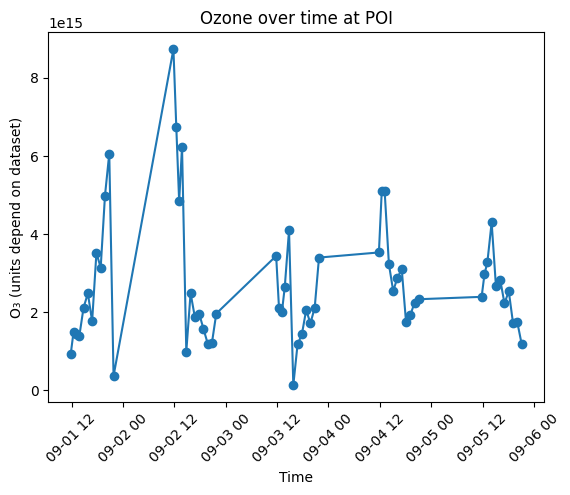

In [7]:
# Assuming you've already searched for TEMPO O3 granules:
files = earthaccess.download(POI_results, "./tempo_data")

times = []
o3_values = []

from tqdm import tqdm

for f in tqdm(files):
    with nc.Dataset(f) as ds:
        prod = ds.groups["product"]

        no2_trop = prod.variables["vertical_column_troposphere"][:]
        qf = prod.variables["main_data_quality_flag"][:]
        lat = ds.variables["latitude"][:]
        lon = ds.variables["longitude"][:]

        i_lat = np.abs(lat - POI_lat).argmin()
        i_lon = np.abs(lon - POI_lon).argmin()

        val = no2_trop[0, i_lat, i_lon]
        if qf[0, i_lat, i_lon] == 0 and val > 0:
            o3_values.append(val)
            # parse time from filename or attribute
            granule_time = ds.time_coverage_start
            times.append(datetime.datetime.fromisoformat(granule_time))

# Plot
plt.plot(times, o3_values, marker="o")
plt.xlabel("Time")
plt.ylabel("O₃ (units depend on dataset)")
plt.title("Ozone over time at POI")
plt.xticks(rotation=45)
plt.show()

In [8]:
!pip install prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwzy13nfo/3s2th0ss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwzy13nfo/d5luzlom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3451', 'data', 'file=/tmp/tmpwzy13nfo/3s2th0ss.json', 'init=/tmp/tmpwzy13nfo/d5luzlom.json', 'output', 'file=/tmp/tmpwzy13nfo/prophet_modelxym0038b/prophet_model-20250926155127.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:51:27 - cmdstanpy - INFO - Chain [1] start processing
INF

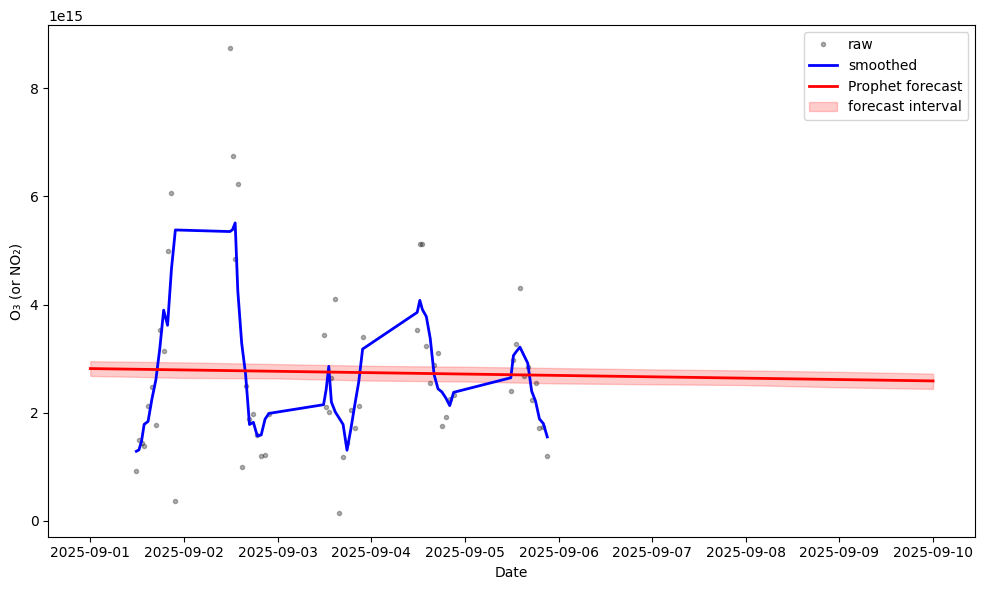

In [20]:
import pandas as pd

# Suppose you already have two lists:
# times = list of datetime objects
# values = list of O3 or NO2 values

df = pd.DataFrame({"ds": times, "y": o3_values}).sort_values("ds")

# Optional: aggregate to daily mean (avoids multiple overpasses per day)
#df = df.resample("1D", on="ds").mean().reset_index()

# Rolling average smoothing (3-day window)
df["y_smooth"] = df["y"].rolling(window=5, center=True, min_periods=1).mean()

from prophet import Prophet

model = Prophet()

# Remove timezone info
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Fit Prophet
model.fit(df_prophet)

# Forecast 30 days ahead
future = model.make_future_dataframe(periods=5)
forecast = model.predict(future)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df["ds"], df["y"], "k.", alpha=0.3, label="raw")
plt.plot(df["ds"], df["y_smooth"], "b-", linewidth=2, label="smoothed")
plt.plot(forecast["ds"], forecast["yhat"], "r-", linewidth=2, label="Prophet forecast")
plt.fill_between(
    forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
    color="r", alpha=0.2, label="forecast interval"
)
plt.xlabel("Date")
plt.ylabel("O₃ (or NO₂)")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
df

,ds,y,y_smooth
0,2025-09-01 00:00:00+00:00,2.474298e+15,2.897464e+15
1,2025-09-02 00:00:00+00:00,3.320631e+15,2.663068e+15
2,2025-09-03 00:00:00+00:00,2.194276e+15,2.861687e+15
3,2025-09-04 00:00:00+00:00,3.070155e+15,2.599534e+15
4,2025-09-05 00:00:00+00:00,2.534172e+15,2.802163e+15


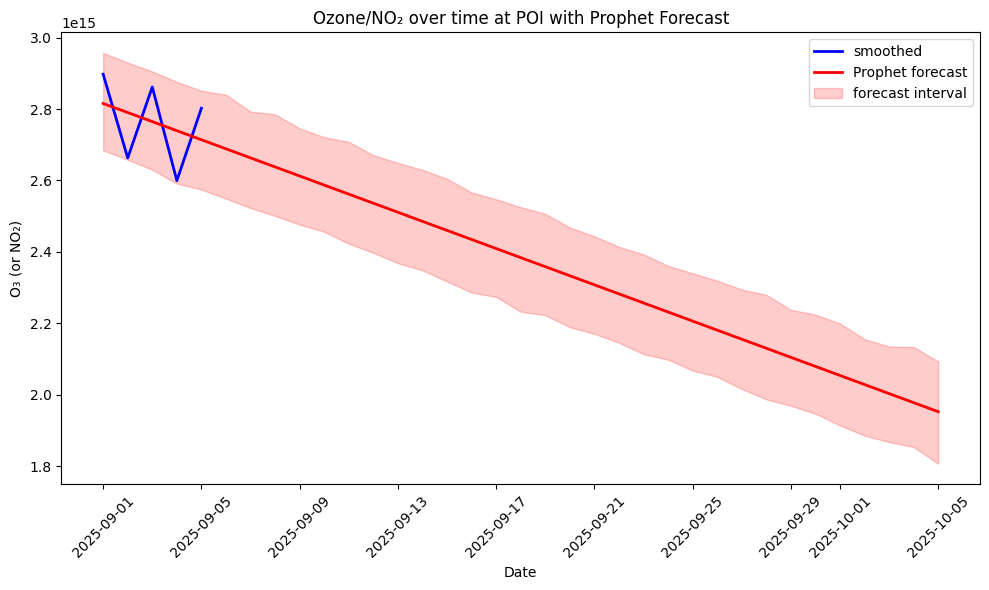

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
# Plot the smoothed data used for Prophet
plt.plot(df_prophet["ds"], df_prophet["y"], "b-", linewidth=2, label="smoothed")
# Plot the Prophet forecast
plt.plot(forecast["ds"], forecast["yhat"], "r-", linewidth=2, label="Prophet forecast")
plt.fill_between(
    forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
    color="r", alpha=0.2, label="forecast interval"
)

plt.xlabel("Date")
plt.ylabel("O₃ (or NO₂)")
plt.title("Ozone/NO₂ over time at POI with Prophet Forecast")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!rm -rf /content/sample_data

In [ ]:
!pip uninstall tensorflow